In [ ]:
import re 
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

# Set base COCA directory
# NOTE: Update this path to wherever COCA is stored locally 
BASE_DIR = Path(r"C:\Users\14046\OneDrive\Desktop\COCA")

TEXT_DIR = BASE_DIR / "coca-text"

# The 5 COCA genres being used 
GENRES = ["acad", "fic", "mag", "news", "spok"]

# Intensifiers  to track 
INTENSIFIERS = ["very", "really", "so", "totally", "super", "literally"]

# Syntax help using: https://www.w3schools.com/python/python_regex.asp
# Regex pattern for intensifiers - whole word match that is case insensitive 
pattern = re.compile(r"\b(very|really|so|totally|super|literally)\b", re.IGNORECASE)

In [ ]:
# Quick regex check
test = "This is so cool but somehow SUPER weird at the same time. Literally amazing!"
pattern.findall(test)

['so', 'SUPER', 'Literally']

In [3]:
# HELPER FUNCTIONS 
# Used for year, decade, and counting

# LLM Assistance: asked "how do I extract the year from file names like text_acad_1990.txt?"
# Extract the 4-digit year from the filename
def get_year_from_filename(path): 
    # getting the path stem and splitting it up by "_" to get each piece (there are 3 total, ex. "text", "spok", "1990") 
    # last piece is the year 
    return int(path.stem.split("_")[2])

# Convert a year to the decade it takes place
def year_to_decade(year):
    return (year // 10) * 10

# LLM-assistance disclosure:
# Prompt used: “How do I structure Python code that counts multiple target words in 
# a text using regex and a dictionary of counters?”
# I applied the suggested pattern (initialize a dict and loop through regex matches),
# adapting it to my intensifier list.
# Count occurences of each intensifier 
def count_intensifiers(text):
    counts = {w: 0 for w in INTENSIFIERS}

    for match in pattern.findall(text): 
        word = match.lower()
        counts[word] += 1 

    return counts

def count_tokens(text):
    return len(text.split())

In [ ]:
# Main extraction loop

records = []

# Loop over each genre 
for genre in GENRES: 
    # Build the path to the folder for that genre
    genre_path = TEXT_DIR / genre 
    print(f"Processing genre: {genre}")

    # LLM assistance: asked "how do I iterate through all .txt files in subfolders?"
    # Get a sorted list of all .txt files in that genre folder 
    text_files = sorted(genre_path.glob("*.txt"))

    # Loop over each file in this genre
    for filepath in text_files:
        # Extract year and compute decade 
        year = get_year_from_filename(filepath)
        decade = year_to_decade(year)

        # Read the file contents into a string
        # LLM-assisted: reading text files 
        # Prompt used (paraphrased): "How do I read .txt documents stored in a folder in Python?"
        try:
            text = filepath.read_text(encoding="utf-8", errors="ignore")
        except UnicodeDecodeError:
            text = filepath.read_text(encoding="latin-1", errors="ignore")
        
        # Count how many times each intensifier appears in the file 
        intensifier_counts = count_intensifiers(text)

        # Count how many tokens are in the file
        token_count = count_tokens(text)

        # Create one row per intensifier (tidy format)
        for word, count in intensifier_counts.items():
            records.append({
                "genre": genre,
                "year": year,
                "decade": decade,
                "intensifier": word,
                "count": count,
                "tokens": token_count,
                "file": filepath.name
            })
    print(f"Finished {genre}: {len(text_files)} files processed. \n")

Processing genre: acad
Finished acad: 30 files processed. 

Processing genre: fic
Finished fic: 30 files processed. 

Processing genre: mag
Finished mag: 30 files processed. 

Processing genre: news
Finished news: 30 files processed. 

Processing genre: spok
Finished spok: 30 files processed. 



In [5]:
# CHECKER CELL 

# How many total extracted rows? 
print(f"Total rows collected: {len(records):,}")

# Look at the first 5 dictionary entries
print("\n Sample records: ")
for r in records[:5]:
    print(r)

# Make sure all the genres were covered
genres_seen = {r['genre'] for r in records}
print("\n Genres found: ", genres_seen)

# Look at years and decade ranges 
year_range = sorted({r['year'] for r in records})
print("\n Year range: ", year_range[:3], "...", year_range[-3:])

decade_range = sorted({r['decade'] for r in records})
print("\n Decade values: ", decade_range)

# Make sure every intensifier was seen 
intensifiers_seen = {r['intensifier'] for r in records}
print("\n Intensifiers found: ", intensifiers_seen)

Total rows collected: 900

 Sample records: 
{'genre': 'acad', 'year': 1990, 'decade': 1990, 'intensifier': 'very', 'count': 2428, 'tokens': 4523764, 'file': 'text_acad_1990.txt'}
{'genre': 'acad', 'year': 1990, 'decade': 1990, 'intensifier': 'really', 'count': 441, 'tokens': 4523764, 'file': 'text_acad_1990.txt'}
{'genre': 'acad', 'year': 1990, 'decade': 1990, 'intensifier': 'so', 'count': 4300, 'tokens': 4523764, 'file': 'text_acad_1990.txt'}
{'genre': 'acad', 'year': 1990, 'decade': 1990, 'intensifier': 'totally', 'count': 145, 'tokens': 4523764, 'file': 'text_acad_1990.txt'}
{'genre': 'acad', 'year': 1990, 'decade': 1990, 'intensifier': 'super', 'count': 39, 'tokens': 4523764, 'file': 'text_acad_1990.txt'}

 Genres found:  {'spok', 'fic', 'acad', 'news', 'mag'}

 Year range:  [1990, 1991, 1992] ... [2017, 2018, 2019]

 Decade values:  [1990, 2000, 2010]

 Intensifiers found:  {'really', 'super', 'totally', 'so', 'very', 'literally'}


In [ ]:
# Convert the list of dicts to a data frame 
df = pd.DataFrame(records)

# Look at the top few rows
print(df.head())

# Make sure all rows and columns are there 
print("\n(Rows, Columns):")
print(df.shape)

  genre  year  decade intensifier  count   tokens                file
0  acad  1990    1990        very   2428  4523764  text_acad_1990.txt
1  acad  1990    1990      really    441  4523764  text_acad_1990.txt
2  acad  1990    1990          so   4300  4523764  text_acad_1990.txt
3  acad  1990    1990     totally    145  4523764  text_acad_1990.txt
4  acad  1990    1990       super     39  4523764  text_acad_1990.txt

(Rows, Columns):
(900, 7)


In [7]:
# LLM-assisted: saving a pandas DataFrame to CSV
# Prompt used (paraphrased): "How do I save a Python data frame to my computer in a clean way?"

# Save as CSV to COCA directory 
output_path = BASE_DIR / "coca_intensifiers_tidy.csv"

df.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

Dataset saved to C:\Users\14046\OneDrive\Desktop\COCA\coca_intensifiers_tidy.csv


In [8]:
# Compute total intensifier counts per decade across genres 
grouped_df = df.groupby(['intensifier', 'decade'])

# Take the sum of each intensifier over the decade 
summary = grouped_df['count'].sum().reset_index() #LLM for reset_index() because before the data frame looked odd 

print(summary)

   intensifier  decade   count
0    literally    1990    6389
1    literally    2000    6853
2    literally    2010    7771
3       really    1990  120987
4       really    2000  134691
5       really    2010  146751
6           so    1990  453115
7           so    2000  487168
8           so    2010  527780
9        super    1990    7369
10       super    2000    8174
11       super    2010   12186
12     totally    1990    9679
13     totally    2000    8328
14     totally    2010    8411
15        very    1990  212339
16        very    2000  196372
17        very    2010  180909


In [9]:
# Total tokens per decade - sum over all files in that decade 
tokens_by_decade = df.groupby('decade')['tokens'].sum().reset_index()

# Remove the duplication for counting for each intensifier
tokens_by_decade['tokens'] = tokens_by_decade['tokens'] // 6 

print(tokens_by_decade)

   decade     tokens
0    1990  242963257
1    2000  241616265
2    2010  240044373


In [10]:
# Merge the summary data with the number of tokens per decade 
merged = summary.merge(tokens_by_decade, on = 'decade')

# Compute the rate per million words
merged['freq_per_million'] = (merged['count'] / merged['tokens']) * 1000000

print(merged)

   intensifier  decade   count     tokens  freq_per_million
0    literally    1990    6389  242963257         26.296157
1    literally    2000    6853  241616265         28.363157
2    literally    2010    7771  240044373         32.373181
3       really    1990  120987  242963257        497.964184
4       really    2000  134691  241616265        557.458332
5       really    2010  146751  240044373        611.349469
6           so    1990  453115  242963257       1864.952773
7           so    2000  487168  241616265       2016.288100
8           so    2010  527780  240044373       2198.676825
9        super    1990    7369  242963257         30.329689
10       super    2000    8174  241616265         33.830504
11       super    2010   12186  240044373         50.765614
12     totally    1990    9679  242963257         39.837299
13     totally    2000    8328  241616265         34.467878
14     totally    2010    8411  240044373         35.039355
15        very    1990  212339  24296325

In [11]:
# LLM: I asked "how do I loop through groups in a data frame and print each one separately?"
# Show just frequencies by decade for each intensifier 
for intensifier in INTENSIFIERS: 
    subset = merged[merged['intensifier'] == intensifier]
    print(f'\n {intensifier.upper()}')
    print(subset[['decade', 'freq_per_million']])


 VERY
    decade  freq_per_million
15    1990        873.955192
16    2000        812.743298
17    2010        753.648160

 REALLY
   decade  freq_per_million
3    1990        497.964184
4    2000        557.458332
5    2010        611.349469

 SO
   decade  freq_per_million
6    1990       1864.952773
7    2000       2016.288100
8    2010       2198.676825

 TOTALLY
    decade  freq_per_million
12    1990         39.837299
13    2000         34.467878
14    2010         35.039355

 SUPER
    decade  freq_per_million
9     1990         30.329689
10    2000         33.830504
11    2010         50.765614

 LITERALLY
   decade  freq_per_million
0    1990         26.296157
1    2000         28.363157
2    2010         32.373181


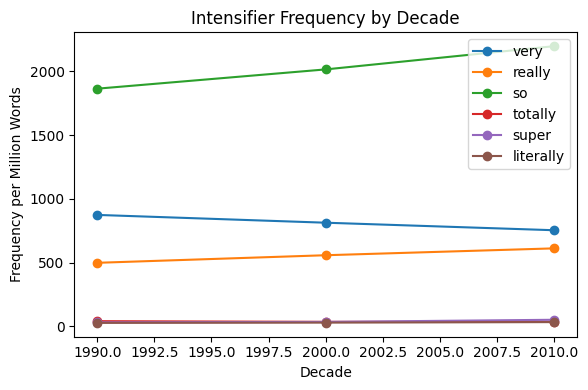

In [12]:
# Simple line plot of frequency per million by decade for each intensifier 
plt.figure(figsize=(6,4))

for word in INTENSIFIERS: 
    subset = merged[merged['intensifier'] == word]

    plt.plot(
        subset['decade'], subset['freq_per_million'], marker = 'o', label = word
    )

plt.xlabel("Decade")
plt.ylabel("Frequency per Million Words")
plt.title("Intensifier Frequency by Decade")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Set up the data for the statistical model 
model_df = df.groupby(['genre', 'intensifier','decade'], as_index=False)[['count', 'tokens']].sum()

# Undo the 6x duplication of tokens 
model_df['tokens'] = model_df['tokens'] // 6 

# Categorical data help from https://pandas.pydata.org/docs/user_guide/categorical.html
model_df['genre'] = model_df['genre'].astype('category')
model_df['intensifier'] = model_df['intensifier'].astype('category')
model_df['decade'] = model_df['decade'].astype('category')

print(model_df)

   genre intensifier decade   count   tokens
0   acad   literally   1990    1171  7796692
1   acad   literally   2000    1062  7737175
2   acad   literally   2010     698  7878705
3   acad      really   1990    5058  7796692
4   acad      really   2000    5300  7737175
..   ...         ...    ...     ...      ...
85  spok     totally   2000    2781  8310987
86  spok     totally   2010    3671  8365240
87  spok        very   1990  103437  8581481
88  spok        very   2000   97790  8310987
89  spok        very   2010   91383  8365240

[90 rows x 5 columns]


In [ ]:
# Used to help explore and get my bearings:

# https://timeseriesreasoning.com/contents/negative-binomial-regression-model/#google_vignette
# https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html
# https://bambinos.github.io/bambi/notebooks/negative_binomial.html
# https://stats.stackexchange.com/questions/66791/where-does-the-offset-go-in-poisson-negative-binomial-regression

In [ ]:
# Statistical model without interactions

for word in INTENSIFIERS:
    print("\n" + "="*80)
    print(f"INTENSIFIER: {word.upper()}")
    
    intensifier_subset = model_df[model_df["intensifier"] == word].copy()

    # Simple negative binomial regression model: decade and genre as additive effects
    # LLM: asked for assistance with Negative Binomial GLM sytax and offset 
    model_simple = smf.glm(
        formula = "count ~ C(decade) + genre",
        data = intensifier_subset,
        family = sm.families.NegativeBinomial(alpha=1.0),
        offset = np.log(intensifier_subset["tokens"])
    )
    
    results = model_simple.fit()

    print(results.summary())


INTENSIFIER: VERY
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      143
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1362.1
Date:                Sun, 07 Dec 2025   Deviance:                       1.2608
Time:                        10:52:07   Pearson chi2:                     1.26
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2997
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          

In [78]:
# Rate ratios for the simple model

for word in INTENSIFIERS:
    print("\n" + "="*80)
    print(f"INTENSIFIER: {word.upper()} — RATE RATIOS")

    intensifier_subset = model_df[model_df["intensifier"] == word].copy()

    # Fit the same simple negative binomial glm as above 
    model_simple = smf.glm(
        formula = "count ~ C(decade) + genre",
        data = intensifier_subset,
        family = sm.families.NegativeBinomial(alpha=1.0),
        offset = np.log(intensifier_subset["tokens"])
    )
    
    results = model_simple.fit()
    
    # Rate ratios
    # LLM assist: asked "how do I get rate ratios from negative binomial GLM coefficients?"
    rrs = np.exp(results.params)
    
    print(rrs)


INTENSIFIER: VERY — RATE RATIOS
Intercept            0.000485
C(decade)[T.2000]    0.915761
C(decade)[T.2010]    0.834307
genre[T.fic]         1.222340
genre[T.mag]         1.295492
genre[T.news]        1.145212
genre[T.spok]        4.355835
dtype: float64

INTENSIFIER: REALLY — RATE RATIOS
Intercept             0.000094
C(decade)[T.2000]     1.120897
C(decade)[T.2010]     1.128202
genre[T.fic]          4.507230
genre[T.mag]          3.838255
genre[T.news]         3.590461
genre[T.spok]        13.710248
dtype: float64

INTENSIFIER: SO — RATE RATIOS
Intercept            0.000829
C(decade)[T.2000]    1.045393
C(decade)[T.2010]    1.040217
genre[T.fic]         2.681249
genre[T.mag]         2.023333
genre[T.news]        1.530572
genre[T.spok]        4.509380
dtype: float64

INTENSIFIER: TOTALLY — RATE RATIOS
Intercept            0.000020
C(decade)[T.2000]    0.872297
C(decade)[T.2010]    0.791571
genre[T.fic]         1.771095
genre[T.mag]         2.022246
genre[T.news]        1.521312
gen

In [88]:
# Statistical model with interactions 

# Interaction model: decade x genre 
for word in INTENSIFIERS:
    print("\n" + "="*80)
    print(f"INTENSIFIER: {word.upper()}")
    
    intensifier_subset = model_df[model_df["intensifier"] == word].copy()

    # Interaction model: decade x genre
    model_inter = smf.glm(
        formula = "count ~ C(decade) * genre",
        data = intensifier_subset,
        family = sm.families.NegativeBinomial(alpha=1.0),
        offset = np.log(intensifier_subset["tokens"])
    )
    
    inter_results = model_inter.fit()

    print(inter_results.summary())


INTENSIFIER: VERY
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      135
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1361.8
Date:                Sun, 07 Dec 2025   Deviance:                      0.60077
Time:                        19:15:56   Pearson chi2:                    0.607
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3028
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

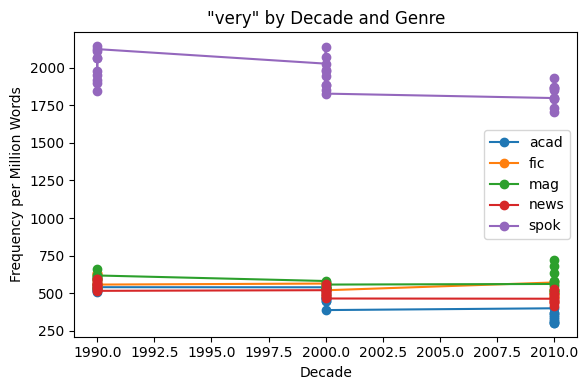

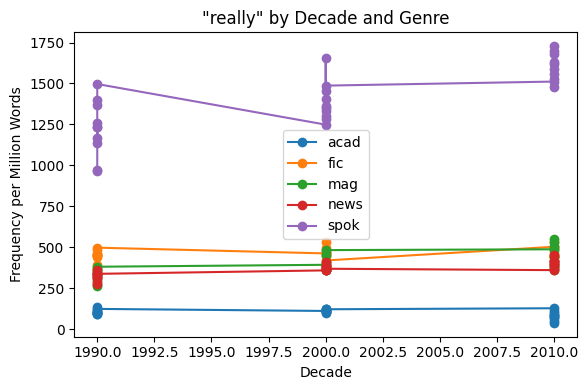

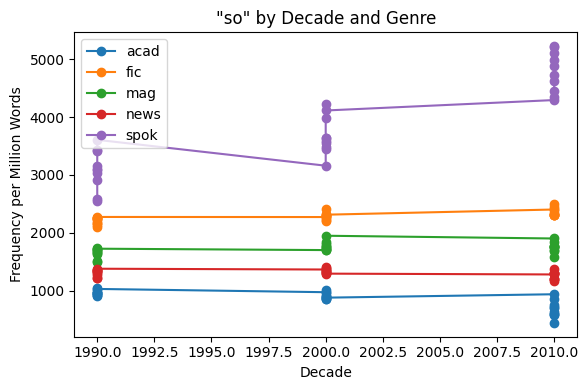

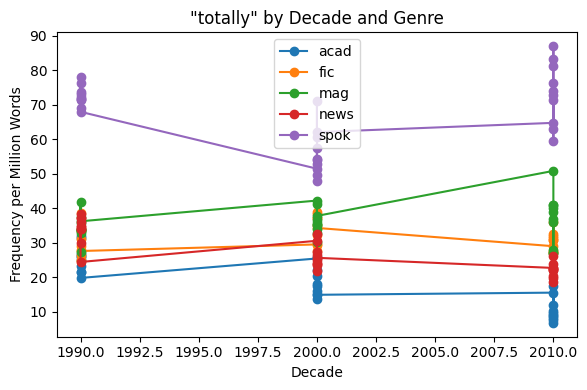

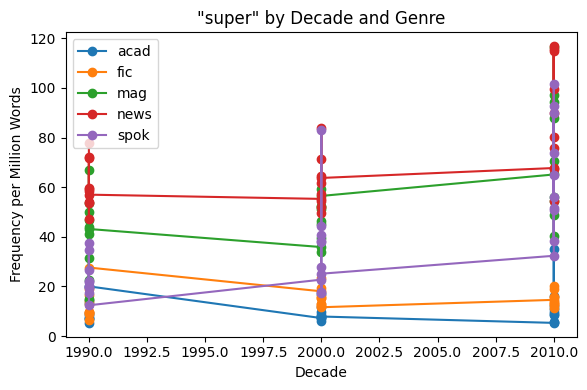

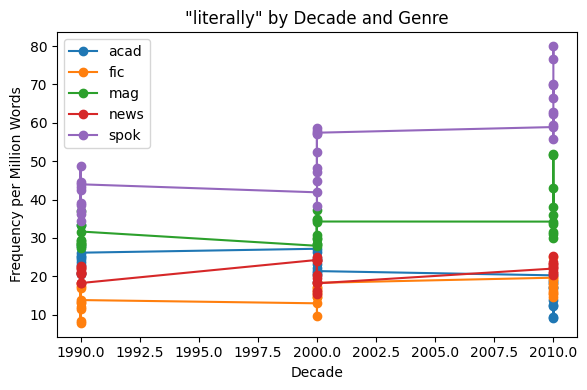

In [ ]:
# Visualization: genre over decade for each intensifier separately 

model_df = df[['genre', 'decade', 'intensifier', 'count', 'tokens']].copy()

# Have to add freq. per million to this df 
model_df['freq_per_million'] = (model_df['count'] / model_df['tokens']) * 1_000_000

for word in INTENSIFIERS: 
    subset_vis = model_df[model_df["intensifier"] == word]

    plt.figure(figsize = (6,4))

    for g in sorted(subset_vis['genre'].unique()): 
        genre_data = subset_vis[subset_vis['genre'] == g]
        plt.plot(
            genre_data['decade'],
            genre_data['freq_per_million'],
            marker = 'o',
            label = g
        )
    
    plt.title(f"\"{word}\" by Decade and Genre")
    plt.xlabel("Decade")
    plt.ylabel("Frequency per Million Words")
    plt.legend()
    plt.tight_layout()
    plt.show()


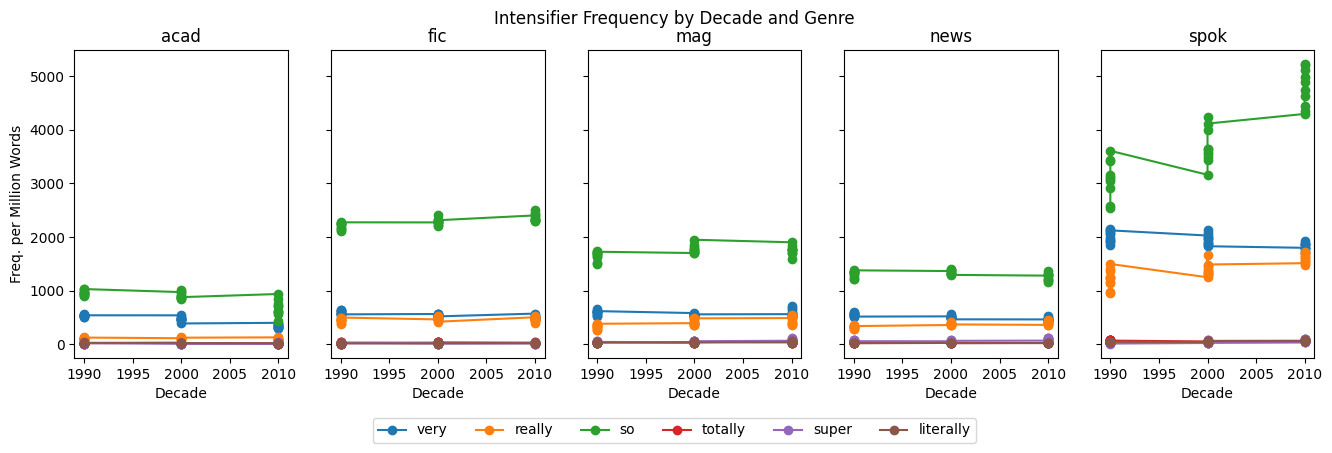

In [ ]:
# LLM assist: help making a multi-panel plot of all intensifiers by genre
# Visualization: Plots split by genre of each intensifier over decade

genres = sorted(model_df["genre"].unique())

fig, axes = plt.subplots(
    1, len(genres), figsize = (16, 4), sharey = True
)

for ax, g in zip(axes, genres): 
    genre_data = model_df[model_df["genre"] == g]

    for word in INTENSIFIERS: 
        sub = genre_data[genre_data["intensifier"] == word]
        ax.plot(
            sub["decade"],
            sub["freq_per_million"],
            marker = "o", 
            label = word
        )
    
    ax.set_title(g)
    ax.set_xlabel("Decade")
    if ax is axes[0]:
        ax.set_ylabel("Freq. per Million Words")

# One legend for the whole figure 
fig.suptitle("Intensifier Frequency by Decade and Genre")
fig.legend(INTENSIFIERS, loc = "lower center", ncol = 6, bbox_to_anchor=(0.5, -0.12))
plt.show()

   decade group   count     tokens  freq_per_million
0    1990   new  476552  971853028        490.353980
1    1990   old  333326  485926514        685.959688
2    2000   new  510523  966465060        528.237410
3    2000   old  331063  483232530        685.100815
4    2010   new  556148  960177492        579.213744
5    2010   old  327660  480088746        682.498815


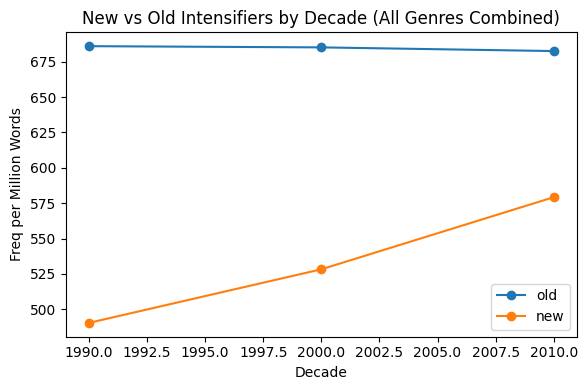

In [43]:
# LLM assist: help grouping intensifiers into "new" vs "old" for a simple decade plot

NEW_WORDS = ["so", "totally", "super", "literally"]
OLD_WORDS = ["very", "really"]

# Label each row as "new" or "old"
model_df["group"] = np.where(
    model_df["intensifier"].isin(NEW_WORDS),
    "new",
    "old"
)

# Sum counts and tokens by decade and group
group_summary = (
    model_df.groupby(["decade", "group"], as_index=False)[["count", "tokens"]].sum()
)

# Compute frequency per million
group_summary["freq_per_million"] = (
    group_summary["count"] / group_summary["tokens"] * 1_000_000
)

print(group_summary)

# Line plot for new vs old intensifiers over decades
plt.figure(figsize=(6, 4))

for grp in ["old", "new"]:
    sub = group_summary[group_summary["group"] == grp]
    plt.plot(
        sub["decade"],
        sub["freq_per_million"],
        marker="o",
        label=grp
    )

plt.xlabel("Decade")
plt.ylabel("Freq per Million Words")
plt.title("New vs Old Intensifiers by Decade (All Genres Combined)")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
# Define which intensifiers are "new"
NEW_WORDS = ["so", "totally", "super", "literally"]

# Aggregate counts and tokens for new intensifiers by decade
new_agg = df[df["intensifier"].isin(NEW_WORDS)] \
    .groupby("decade", as_index=False)[["count", "tokens"]].sum()

# Compute frequency per million
new_agg["freq_per_million"] = (new_agg["count"] / new_agg["tokens"]) * 1_000_000

print(new_agg)

# Define which intensifiers are "old"
OLD_WORDS = ["very", "really"]

old_agg = df[df["intensifier"].isin(OLD_WORDS)] \
    .groupby("decade", as_index=False)[["count", "tokens"]].sum()

# Compute frequency per million
old_agg["freq_per_million"] = (old_agg["count"] / old_agg["tokens"]) * 1_000_000

print("")
print(old_agg)

   decade   count     tokens  freq_per_million
0    1990  476552  971853028        490.353980
1    2000  510523  966465060        528.237410
2    2010  556148  960177492        579.213744

   decade   count     tokens  freq_per_million
0    1990  333326  485926514        685.959688
1    2000  331063  483232530        685.100815
2    2010  327660  480088746        682.498815


In [59]:
# NEW intensifiers
new_slope, new_intercept = np.polyfit(
    new_agg["decade"], 
    new_agg["freq_per_million"], 
    1
)

print("New intensifiers slope:", new_slope)

# OLD intensifiers
old_slope, old_intercept = np.polyfit(
    old_agg["decade"], 
    old_agg["freq_per_million"], 
    1
)

print("Old intensifiers slope:", old_slope)

New intensifiers slope: 4.442988210723916
Old intensifiers slope: -0.17304368173161594


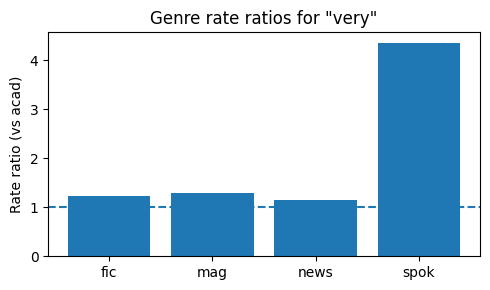

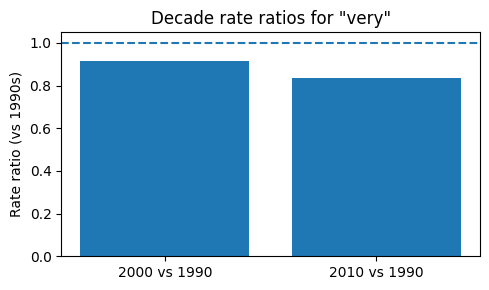

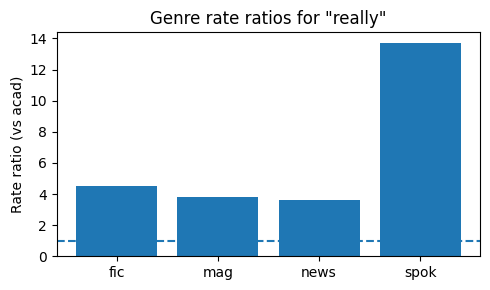

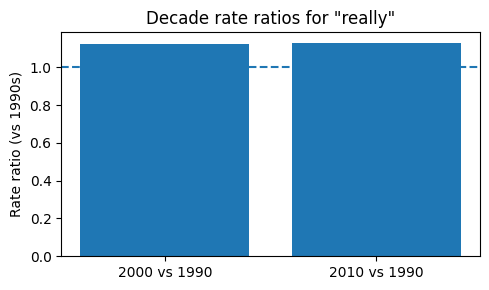

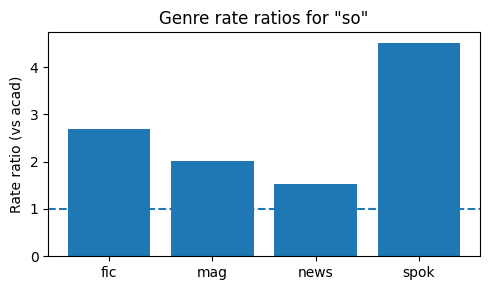

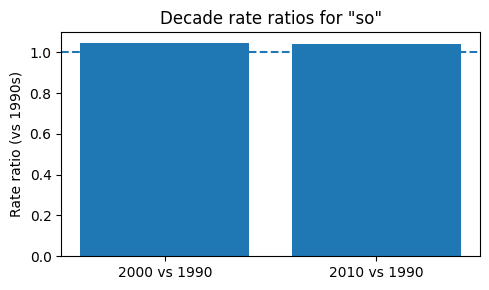

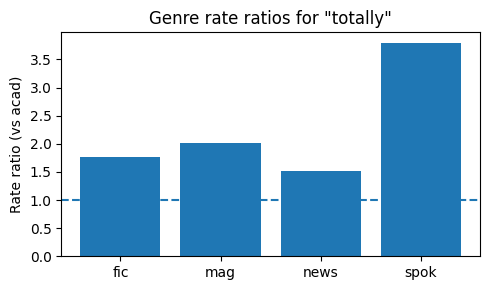

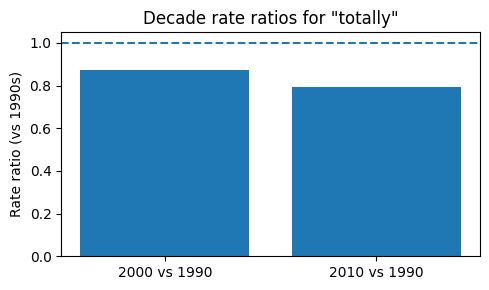

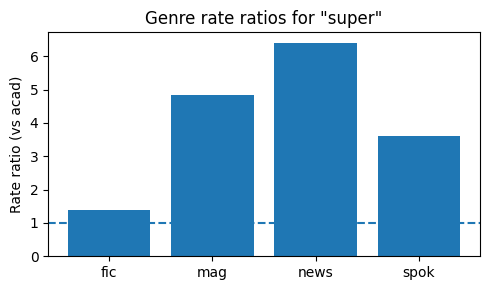

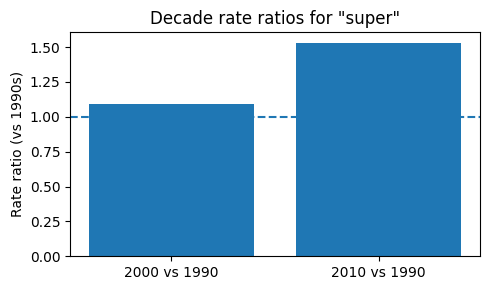

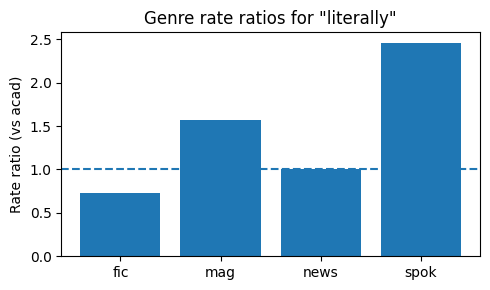

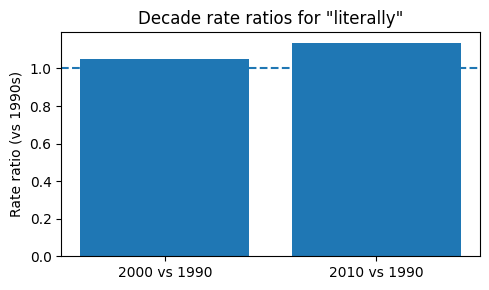

In [ ]:
# Visualization: rate ratios for individual intensifiers

all_rate_ratios = {}

for word in INTENSIFIERS:
    # Subset for one intensifier
    intensifier_subset = model_df[model_df["intensifier"] == word].copy()

    # Fit the simple (additive) NB model
    model_simple = smf.glm(
        formula="count ~ C(decade) + genre",
        data=intensifier_subset,
        family=sm.families.NegativeBinomial(alpha=1.0),
        offset=np.log(intensifier_subset["tokens"])
    )
    results_simple = model_simple.fit()

    # Exponentiate coefficients → rate ratios
    rr = np.exp(results_simple.params)
    all_rate_ratios[word] = rr

    # Genre rate ratios bar plot
    genre_terms = ["genre[T.fic]", "genre[T.mag]", "genre[T.news]", "genre[T.spok]"]
    genre_labels = ["fic", "mag", "news", "spok"]
    genre_rr = [rr.get(term, np.nan) for term in genre_terms]

    plt.figure(figsize=(5, 3))
    plt.bar(genre_labels, genre_rr)
    plt.axhline(1.0, linestyle="--")  # baseline = academic
    plt.ylabel("Rate ratio (vs acad)")
    plt.title(f'Genre rate ratios for "{word}"')
    plt.tight_layout()
    plt.show()

    # Decade rate ratios bar plot 
    decade_terms = ["C(decade)[T.2000]", "C(decade)[T.2010]"]
    decade_labels = ["2000 vs 1990", "2010 vs 1990"]
    decade_rr = [rr.get(term, np.nan) for term in decade_terms]

    plt.figure(figsize=(5, 3))
    plt.bar(decade_labels, decade_rr)
    plt.axhline(1.0, linestyle="--")  # baseline = 1990s
    plt.ylabel("Rate ratio (vs 1990s)")
    plt.title(f'Decade rate ratios for "{word}"')
    plt.tight_layout()
    plt.show()